# Ion Entanglement Using Segmented Pulses

### Code Setup

In [1]:
import numpy as np
from numpy import sin, cos, exp, sqrt, angle
import scipy.integrate as integrate
import scipy.linalg as linalg
import matplotlib.pyplot as plt

In [2]:
import importlib
import sys, os
from pathlib import Path
sys.path.append('tools/')
import IonChainTools as ict
import MSFidelityEstimation as msfe
importlib.reload(msfe)
from MSFidelityEstimation import *

We perform calculations to demonstrate how to use segmented pulses to perform entangling gates at any detuning, as described in ["Optimal Quantum Control of Multimode Couplings between Trapped Ion Qubits
for Scalable Entanglement"(2014)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.112.190502).

### Tools

In [3]:
def separateStrengthAndPhase(vec):
    ''' Take a vector of complex values and split each value into a magnitude and a phase. '''
    magnitudes = [abs(a) for a in vec]
    phases = [angle(a) for a in vec]
    return magnitudes, phases

In [4]:
def get_bin(x, n):
    ''' Turn a number x into a binary representation as a n-long vector of integers 0 or 1. '''
    string = format(x, 'b').zfill(n)
    return [int(c) for c in string]

In [5]:
def coherent_innerprod(αbra, αket):
    ''' Inner product of two coherent states, i.e. <αbra|αket>'''
    return exp(-1/2*(abs(αket)**2+abs(αbra)**2-2*αbra.conjugate()*αket))

In [6]:
def trace_over_motion(qbitstate, motionalstate):
    ''' Trace over motional state to get only state of qubits.
        Params :
            qbitstate : Vector of coefficients for each qubit eigenstate (ex. [1,0,0,-i] is a bell state)
            motionalstate : Vector of vector of α values for modes. motionalstate[3][1] is the α value for
                        the second mode associated with the qubit state |10> (assuming there are 2 qubits).
        Returns :
            ρ : qutip.Qobj density matrix describing qubits.
    '''
    N = int(np.log2(len(qbitstate)))
    ρ = np.zeros((2**N,2**N),dtype=np.complex_)
    for estateket_index in range(2**N):
        for estatebra_index in range(2**N):
            tracecoeff = np.prod([coherent_innerprod(motionalstate[estatebra_index][k], motionalstate[estateket_index][k]) for k in range(N)])
            ρ[estatebra_index, estateket_index] = qbitstate[estatebra_index].conjugate()*qbitstate[estateket_index]*tracecoeff
    ρ = qtp.Qobj(ρ, [[2]*N,[2]*N], [2**N,2**N])
    return ρ

In [7]:
def convert_x_to_z_basis(ρ):
    ''' Convert ρ from x basis to z basis.'''
    x_to_z_operator = tensor([qtp.Qobj(1/sqrt(2)*np.array([[1,1],[1,-1]]),[[2],[2]],[2,2])]*N)
    return x_to_z_operator*ρ*x_to_z_operator.dag()

## Pulse Optimization

### Unitary

The gate unitary is given by

$$
U_{MS}(t) = \exp\left( \sum_{i,k} \sigma_{i} (\alpha_{i,k}a_k^\dagger + \alpha_{i,k}a_k) + \sum_{i,j} \chi_{i,j} \sigma_{i} \sigma_{j} \right)
$$

where $\sigma_i$ is a rotation on qubit $i$ around some axis determined by the relative phases of the lasers and $a_k$ is the lowering operator for mode $k$. We'll assume that $\sigma$ is an X rotation.

### Mode Loop Closure Constraints

In order to close the phase space loop associated with each ion, we must satisfy the condition

$$
\alpha_{i,k} = -\frac{i}{2} \eta_{i,k} \int_0^\tau \Omega_i(t) e^{i(\nu_k-\omega_d)t} dt = 0.
$$

We define this as a linear constraint of finite dimension by segmenting the pulse into $D$ segments. We'll also assume that $\Omega_{t_1}(t)=\Omega_{t_2}(t)$ for the target ions $t_1, t_2$ and also assume that $\Omega_{i}(t)=0$ for all spectator ions $i$. Thus instead of searching for functions $\Omega_i(t)$, we will look for a single D-element vector $\Omega$ where each vector element is the rabi frequency for the corresponding segment of the pulse being applied to the target ions.

$$
\Omega_{t_1}(t) = \Omega_{t_2}(t) = \Omega_{\lfloor tD/\tau \rfloor}
$$

For each target ion $i$, we can now state

\begin{align}
\alpha_{i,k} &= -\frac{i}{2}\eta_{i,k} \sum_{s=0}^{D-1} \Omega_s \left( \int_{s\tau/D}^{(s+1)\tau/D} e^{i(\nu_k-\omega_d)t} dt \right) = 0
\\
&= -\frac{i}{2} \sum_{s=0}^{D-1} \Omega_s \left(-i\eta_{i,k}\frac{e^{i(\nu_k-\omega_d)(s+1)\tau/D}-e^{i(\nu_k-\omega_d)s\tau/D}}{\nu_k-\omega_d}\right)
\\
&=: \sum_{s=0}^{D-1} \Omega_s A_{i,k,s}
\end{align}

For each of the target ions $i$, we can define $A_{i}$ as a matrix with one row for each mode and the requirement that $\Omega$ must be perpendicular to each row. However we can now note that factor of the Lamb-Dicke parameter doesn't affect the null space, so we can calculate a mode-closing $\Omega$ vector just from the detuning $\omega_d$ and have it work when the pulse is applied to any ion in the string. Thus we use the same pulse shape for both target ions.

In [8]:
def getModeClosingPulseBasis(targets, D, τ, ωd, devicespec):
    ν_k = lambda k : devicespec.modes('radial')[k].freq
    A = []
    for k in range(devicespec.N):
        complex_requirement = [(exp(1j*(ν_k(k)-ωd)*(s+1)*τ/D)-exp(1j*(ν_k(k)-ωd)*s*τ/D))/(ν_k(k)-ωd)
                    for s in range(D)]
        complex_requirement = np.array(complex_requirement)
        A.append(complex_requirement.real)
        A.append(complex_requirement.imag)
    A = np.array(A)
    return linalg.null_space(A).T

### Target Gate Angle Constraint

The XX rotation angle between ions $i$ and $j$ is given by

$$
\chi_{i, j} = -\frac{1}{4} \sum_k \eta^k_{i}\eta^k_{j} \int_0^\tau \int_0^t \Omega_{i}(t) \Omega_{j}(t') \sin((\omega_d-\nu_k)(t-t')) dt' dt
$$

Working with $i=t_1, j=t_2$, we once again chop the time integral up into segments. Chopping up the outer integral into $D$ equal segments is as straightforward as for the mode displacement calculation. Segmenting the inner integral is slightly more complicated because the upper bound of the inner integral does not always fall at the end of a segment. We can visualize the double integral as being over a triangular region with axes $t$ and $t'$. Segmenting the triangle along lines $t=s\tau/D$ and $t'=s'\tau/D$ for integer values of $s, s'$ divides the triangle into rectangular regions off the diangonal and triangular regions on the diagonal. In the below expression, the summation over $s'$ indicates the rectangular regions while the second term in the parenthesis handles integration over triangular regions where $s=s'$.

\begin{align}
\chi_{t_1,t_2} & = -\frac{1}{4} \sum_k \eta_{t_1}^k \eta_{t_2}^k \sum_{s_1=0}^{D-1} \Omega_{t_1,s_1} \int_{s_1\tau/D}^{(s_1+1)\tau/D} \left( \sum_{s_2=0}^{s_1-1} \Omega_{t_2,s_2} \int_{s_2\tau/D}^{(s_2+1)\tau/D} \sin((\omega_d - \nu_k)(t-t')) dt' dt + \Omega_{t_2,s_1} \int_{s_1\tau/D}^t \sin((\omega_d - \nu_k)(t-t')) dt' dt\right)
\\
& = \pi/4
\end{align}

Once again we evaluate the integrals and package the requirement into a matrix-vector equation:

$$
\chi_{t_1, t_2} = \sum_{s_1=0}^{D-1} \sum_{s_2=0}^{D-1} B_{t_1, t_2, s_1, s_2} \Omega_{t_1,s_1} \Omega_{t_2,t_2} = \Omega_{t_1}^{\text{T}} B_{t_1, t_2} \Omega_{t_2} = \pi/4
$$

where

$$
B_{t_1,t_2,s_1,s_2} = -\frac{1}{4} \sum_k \eta^k_{t_1} \eta^k_{t_2}
\begin{cases}
\int_{s_1\tau/D}^{(s_1+1)\tau/D} \int_{s_2\tau/D}^{(s_2+1)\tau/D} \sin((\omega_d-\nu_k)(t-t')) dt' dt & \quad \text{if} \quad s_2 < s_1
\\
\int_{s_1\tau/D}^{(s_1+1)\tau/D} \int_{s_2\tau/D}^t \sin((\omega_d-\nu_k)(t-t')) dt' dt & \quad \text{if} \quad s_2=s_1
\\
0 & \quad \text{if} \quad s_2>s_1
\end{cases}
$$

Furthermore we can evaluate the integrals used to define the $B$ matrix. This gives us

\begin{align}
& \int_{s_1\tau/D}^{(s_1+1)\tau/D} \int_{s_2\tau/D}^{(s_2+1)\tau/D} \sin((\omega_d-\nu_k)(t-t')) dt' dt
\\
& \quad = \frac{2\sin((\omega_d-\nu_k)((s_1-s_2)\tau/D))-\sin((\omega_d-\nu_k)((s_1-s_2+1)\tau/D))-\sin((\omega_d-\nu_k)((s_1-s_2-1)\tau/D))}{(\omega_d-\nu_k)^2}
\\
& \quad \text{for} \quad s_2\lt s_1
\end{align}

\begin{align}
& \int_{s_1\tau/D}^{(s_1+1)\tau/D} \int_{s_1\tau/D}^t \sin((\omega_d-\nu_k)(t-t')) dt' dt
\\
& \quad = \frac{\tau/D}{\omega_d-\nu_k} - \frac{\sin((\omega_d-\nu_k)\tau/D)}{(\omega_d-\nu_k)^2}
\\
& \quad \text{for} \quad s_2=s_1
\end{align}

In [9]:
def getGateAngle(ionpair, Ω, τ, ωd, devicespec):
    ''' Angle of XX rotation between ionpair. Ω is 2-vector of pulse shape vectors. '''
    N = devicespec.N
    D = len(Ω[0])
    θ = 0
    for k in range(N):
        δ = ωd-devicespec.modes('radial')[k].freq
        LD_product = devicespec.LDparam(k,'radial',ionpair[0])*devicespec.LDparam(k,'radial',ionpair[1])
        for s0 in range(D):
            for s1 in range(D):
                if s1 < s0:
                    θ += Ω[0][s0]*Ω[1][s1]*LD_product*-1/4*(2*sin(δ*(s0-s1)*τ/D)+sin(δ*(s0-s1+1)*τ/D)+sin(δ*(s0-s1-1)*τ/D))/δ**2
                    θ += Ω[1][s0]*Ω[0][s1]*LD_product*-1/4*(2*sin(δ*(s0-s1)*τ/D)+sin(δ*(s0-s1+1)*τ/D)+sin(δ*(s0-s1-1)*τ/D))/δ**2
                elif s1 == s0:
                    θ += Ω[0][s0]*Ω[1][s1]*LD_product*-1/4*((τ/D)/δ - sin(δ*τ/D)/δ**2)
                    θ += Ω[1][s0]*Ω[0][s1]*LD_product*-1/4*((τ/D)/δ - sin(δ*τ/D)/δ**2)
    return θ

In [10]:
def generateOptimalPulse(targets, D, τ, devicespec):
    N = devicespec.N
    neighbors = [i for i in range(N) if i in (targets[0]-1,targets[0]+1,targets[1]-1,targets[1]+1) and i not in targets]
    xtalkpairs = list(itertools.product(targets, neighbors))
    min_detuning = devicespec.modes('radial')[0].freq - 0.1e6*2*π
    max_detuning = devicespec.modes('radial')[-1].freq + 0.1e6*2*π
    errgate_str_by_detuning = []
    for ωd in np.arange(min_detuning,max_detuning,1e2*2*π):
        Ω = getModeClosingPulseBasis(targets, D, τ, ωd, devicespec)[0]
        target_strength = getGateAngle(targets, np.array([Ω,Ω]), τ, ωd, devicespec)
        errgate_str = sum([(getGateAngle(xtalkpair, np.array([Ω,Ω/10]), τ, ωd, devicespec)/target_strength)**2 for xtalkpair in xtalkpairs])
        errgate_str_by_detuning.append((ωd, errgate_str))
    errgate_str_by_detuning = np.array(errgate_str_by_detuning)
    bestωd = errgate_str_by_detuning[np.argmin(errgate_str_by_detuning[:,1])][0]
    Ω = getModeClosingPulseBasis(targets, D, τ, bestωd, devicespec)[0]
    unscaledθ = getGateAngle(targets, np.array([Ω,Ω]), τ, bestωd, devicespec)
    Ω *= sqrt((π/4)/abs(unscaledθ)) # Make sure gate is XX(π/4)
    return bestωd, [Ω, Ω*np.sign(unscaledθ)] # Flip the phase on one ion to get positive gate angle

## MS Gate Unitary

In [11]:
def getMSState(t, τ, Ω, ωd, devicespec):
    '''
        t : Time to get state for
        τ : Total gate time (used for interpreting Ω)
        Ω : Rabi freqs, indexed as [ion index, segment index]
        ωd : Detuning from carrier (for blue beam)
        devicespec : TIDeviceSpec object
    '''
    N = devicespec.N
    qbitstate = np.ones(2**N, dtype=np.complex_)/sqrt(2**N) # Coefficients in x-basis (All coeffeficients equal corresponds to 0z state)
    motionalstate = np.zeros((2**N,N),dtype=np.complex_) # Coherent state α values for each mode for each qubit state

    D = len(Ω[0]) # Number of segments

    # αki[k,i] is the contribution of ion i to the α-value displacement of mode k
    αki = np.zeros((N,N), dtype=np.complex_)
    G = np.zeros((N,D,D)) # Triangular matrix for each mode
    for k in range(N):
        νk = devicespec.modes('radial')[k].freq
        δ = ωd-νk
        for i in range(N):
            αk_without_η = 0
            for s in range(D):
                # s dictates start time of pulse segment
                if (s+1)*τ/D < t: uppertime = (s+1)*τ/D
                else: uppertime = t # If t occurs before end of segment, use only run until time t
                αk_without_η += -1*Ω[i][s]*(exp(1j*(νk-ωd)*uppertime)-exp(1j*(νk-ωd)*(s*τ/D)))/(νk-ωd)
                if (s+1)*τ/D >= t: break
            η = devicespec.LDparam(k, "radial", i)
            αki[k,i] = αk_without_η*η
        for s in range(D):
            for sprime in range(D):
                if sprime < s:
                    G[k,s,sprime] = -1/4*(2*sin(δ*(s-sprime)*τ/D)+sin(δ*(s-sprime+1)*τ/D)+sin(δ*(s-sprime-1)*τ/D))/δ**2
                elif sprime == s:
                    G[k,s,sprime] = -1/4*((τ/D)/δ - sin(δ*τ/D)/δ**2)
                # Else if sprime>s, leave G entry as 0

    # Calculate angle of XX rotation between all ion pairs (i,j)
    χij = np.zeros((N,N), dtype=np.complex_)
    for i,j in itertools.product(range(N),range(N)):
        B = sum([devicespec.LDparam(k, "radial", i)*devicespec.LDparam(k, "radial", j)*G[k] for k in range(N)])
        χij[i,j] = Ω[i].T@B@Ω[j] # i corresponds to s, j corresponds to s'
            
    # eigenstateindex is an integer whose binary representation indicate an x-basis eigenstate of the string
    for eigenstateindex in range(2**N):
        eigenstatevals = np.array(get_bin(eigenstateindex, N))*-2+1 # Convert int to bitstring to vector with 0->+1, 1->-1
        # Calculate motional state corresponding to this qubit eigenstate
        for k in range(N):
            # Sum state-dependent contributions to motional mode displacement
            motionalstate[eigenstateindex][k] = sum([αki[k,i]*eigenstatevals[i] for i in range(N)])
        # Calculate phase imparted on this eigenstate by all XX interactions
        totalXXrotationangle = sum(eigenstatevals[i]*eigenstatevals[j]*χij[i,j] for i,j in itertools.product(range(N),range(N)))
        qbitstate[eigenstateindex] *= exp(1j*totalXXrotationangle)
    
    return qbitstate, motionalstate

## Testing

In [12]:
from scipy.constants import physical_constants
M=40*physical_constants['atomic mass constant'][0]

qbit_splitting = 2*π*4.1115503520574475e14 # 729nm
#raman_wavelen = 355*1e-9 # 355nm, from "frequency robust ..." paper
#raman_freq = 2*π*scipy.constants.c/raman_wavelen
kvec = qbit_splitting/scipy.constants.c

νz = 2*π*0.32*1e6 # 0.52MHz + 0.5MHz to make radial mode spacing larger
νr = 2*π*2.296*1e6 # 2.296MHz

N = 6

D = 2*N+1
τ = 300e-6

targets=(0,1)

trapspec = TrapSpec(νz, νr)
devicespec = TIDeviceSpec(N, trapspec, qbit_splitting, M=M)

In [13]:
def calcFidelityForModeClosedPulse(targets, ωd, τ, D, xtfrac, devicespec):
    N = devicespec.N
    neighbors = [i for i in range(N) if i in (targets[0]-1,targets[0]+1,targets[1]-1,targets[1]+1) and i not in targets]
    Ω = getModeClosingPulseBasis(targets, D, τ, ωd, devicespec)[0]
    θ_before_scaling = getGateAngle(targets, np.array([Ω,Ω]), τ, ωd, devicespec)
    Ω *= sqrt((π/4)/abs(θ_before_scaling))
    Ω_byion = []
    for i in range(N):
        if i== targets[0]: Ω_byion.append(Ω)
        # Flip phase on second target ion if necessary to make gate angle positive (+π/4 instead of -π/4)
        elif i==targets[1]: Ω_byion.append(Ω*np.sign(θ_before_scaling))
        # Consider crosstalk on nearest neighbors to simply be some fraction of the pulse on the first target ion
        # This doesn't account for a neighbor of the second target ion having crosstalk with a flipped phase if
        # the pulse on the second target ion is flipped.
        elif i in neighbors: Ω_byion.append(Ω*xtfrac)
        else: Ω_byion.append(np.zeros(D))
    qbitstate, motionalstate = getMSState(τ, τ, Ω_byion, ωd, devicespec)
    ρ_xbasis = trace_over_motion(qbitstate, motionalstate)
    ρ = convert_x_to_z_basis(ρ_xbasis)
    ψbell1 = qtp.ket2dm(1/sqrt(2)*(tensor(basis(2,0),basis(2,0))+1j*tensor(basis(2,1),basis(2,1))))
    ψbell2 = qtp.ket2dm(1/sqrt(2)*(tensor(basis(2,0),basis(2,0))-1j*tensor(basis(2,1),basis(2,1))))
    fid = (ψbell2.dag()*ρ.ptrace(targets)).tr()
    return fid

In [14]:
def plotFidelityByDetuning(targets, τ, D, xtfrac, devicespec, plotmodes=False):
    N = devicespec.N
    neighbors = [i for i in range(N) if i in (targets[0]-1,targets[0]+1,targets[1]-1,targets[1]+1) and i not in targets]
    min_detuning = devicespec.modes('radial')[0].freq - 0.1e6*2*π
    max_detuning = devicespec.modes('radial')[-1].freq + 0.1e6*2*π
    fid_by_detuning = []
    for ωd in np.arange(min_detuning,max_detuning,1e3*2*π+1):
        fid = calcFidelityForModeClosedPulse(targets, ωd, τ, D, xtfrac, devicespec)
        fid_by_detuning.append((ωd, fid.real))
    fid_by_detuning = np.array(fid_by_detuning)
    fig, ax = plt.subplots()
    ax.plot(fid_by_detuning[:,0]/(2*π),abs(fid_by_detuning[:,1]))
    if plotmodes:
        for mode in devicespec.modes('radial'):
            ax.vlines(x=mode.freq/(2*π),ymin=0,ymax=1, color="green") 

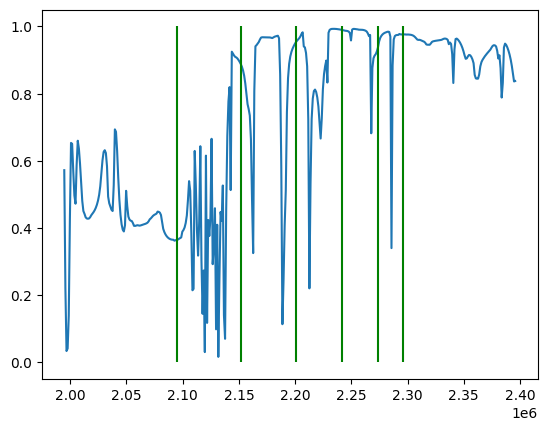

In [15]:
plotFidelityByDetuning((0,2), τ, D, 0.1, devicespec, plotmodes=True)

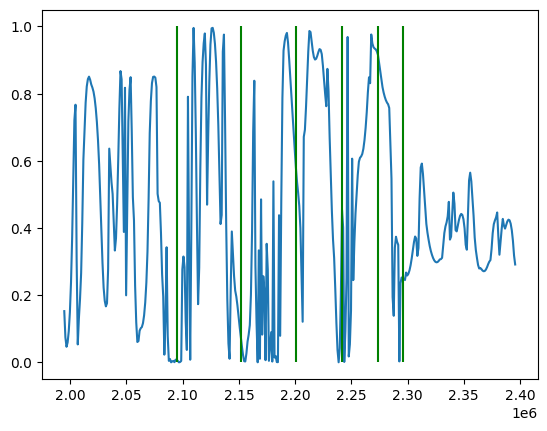

In [16]:
plotFidelityByDetuning((0,1), τ, D, 1, devicespec, plotmodes=True)

In [17]:
[mode.freq/(2*π) for mode in devicespec.modes('radial')]

[2094662.6658530196,
 2151953.8148836,
 2200908.3130584913,
 2241568.024554314,
 2273590.9922425286,
 2296000.000000001]

## Mode Displacement Path

In [18]:
import matplotlib.cm as cm

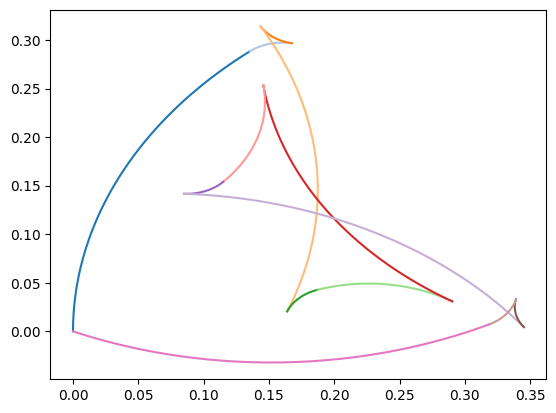

In [19]:
λ = 2 # Which qubit eigenstate to plot the associated motion of
k = 2 # Which mode to plot displacement of
fig, ax = plt.subplots()
t=τ
targets = (0,1)
ωd, Ω_targetions = generateOptimalPulse(targets, D, τ, devicespec)
Ω_byion = []
for i in range(N):
    if i==targets[0]: Ω_byion.append(Ω_targetions[0])
    elif i==targets[1]: Ω_byion.append(Ω_targetions[1])
    else: Ω_byion.append(np.zeros(D)) # No crosstalk
for s in range(D):
    if (s+1)*τ/D < t: uppertime = (s+1)*τ/D
    else: uppertime = t
    αvals = [getMSState(tprime, τ, Ω_byion, ωd, devicespec)[1][λ][k] for tprime in np.linspace(s*τ/D, uppertime, 100)]
    ax.plot(np.real(αvals), np.imag(αvals), color=cm.tab20(s))
    if (s+1)*τ/D >= t: break
    # print(s)